# Multiple Classifer Comparision using Term frequency-inverse document frequency(TF-IDF) weights to train model
*adapted using https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f*

In [0]:
%matplotlib inline
import re
import enum
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import json
from pprint import pprint
import csv
from ast import literal_eval


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cleaned_trinary.csv')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cleaned_trinary_training_70.csv')
# df.tags = df.tags.apply(literal_eval)

df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cleaned_trinary_test_30.csv')
df.head()

,id,tags,object_labels
0,a1f0fd29e6ae9a8618baac0a27e13676e192ee03c38e79...,HighCrime,"Human,Person,Gun,Weapon,Weaponry,Military,Mili..."
1,68934fb5c279c38cda8e88fa67d2d6a664ec3fefac0793...,NoCrime,"Human,Person,Art,Automobile,Transportation,Veh..."
2,73e74e658d83ec20d35cf16ce461b9538ecdc59ea70ff8...,NoCrime,"Plot,Text,Diagram,Number,Symbol,Page,Document,..."
3,676508fcd73d674bac82600e02b5d58a562a7493046baf...,NoCrime,"Text,Poster,Advertisement,Handwriting,Word"
4,7a6c29f171fe6d3b550f24d7650c229e298c67fc2bbef3...,NoCrime,"Human,Person,Face,Crowd,Audience,Speech,Finger..."


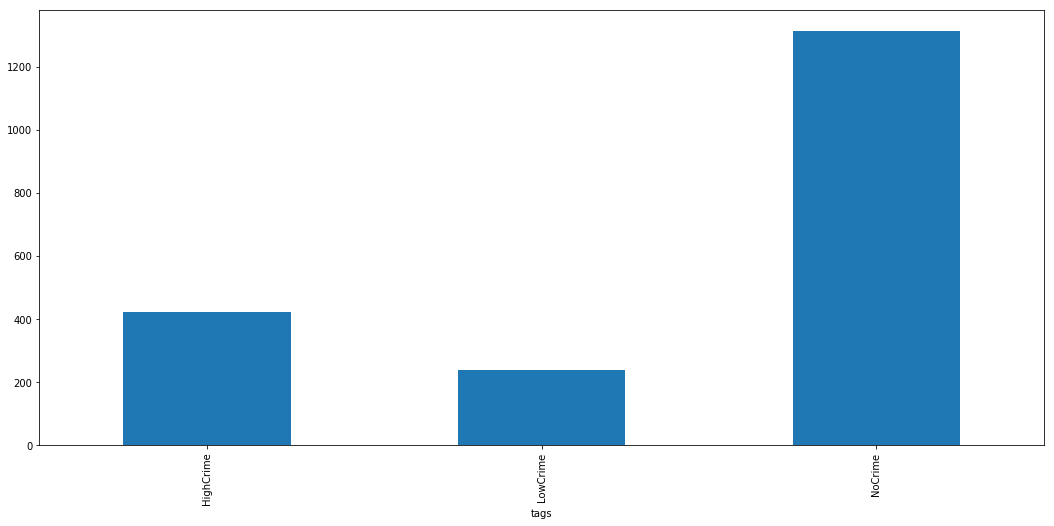

In [0]:
a = pd.Series([item for item in df.tags])
df_a = a.value_counts().sort_index().rename_axis('tags').reset_index(name='f')
# df_a.head()
df_a = df_a.set_index('tags')
# df_a.info()

plt.subplots(figsize=(18,8))
df_a['f'].plot.bar()

In [0]:
df_a.head()
# df.info()

,f
tags,
HighCrime,421
LowCrime,238
NoCrime,1314


### Represent the cateogories using a number

In [0]:
from io import StringIO

# Training set
col = ['tags_string', 'object_labels']
df['tags_string'] = df['tags']

df = df[col]
df = df[pd.notnull(df['object_labels'])]
df.columns = ['tags_string', 'object_labels']
df['category_id'] = df['tags_string'].factorize()[0]
category_id_df = df[['tags_string', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'tags_string']].values)
df.head()

# Test set
col = ['tags_string', 'object_labels']
df_test['tags_string'] = df_test['tags']

df_test = df_test[col]
df_test = df_test[pd.notnull(df_test['object_labels'])]
df_test.columns = ['tags_string', 'object_labels']
df_test['category_id'] = df_test['tags_string'].factorize()[0]
category_id_df = df_test[['tags_string', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'tags_string']].values)

# df_test.head()

In [0]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 846 entries, 0 to 846
Data columns (total 3 columns):
tags_string      846 non-null object
object_labels    846 non-null object
category_id      846 non-null int64
dtypes: int64(1), object(2)
memory usage: 26.4+ KB


In [0]:
# df.head()
# category_id_df
print(category_to_id)

{'HighCrime': 0, 'NoCrime': 1, 'LowCrime': 2}


## Tf-Idf
presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

- ``sublinear_df`` is set to True to use a logarithmic form for frequency.
- ``min_df`` is the minimum numbers of documents a word must be present in to be kept.
- ``norm`` is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
- ``ngram_range`` is set to (1, 1) to indicate that we want to consider only unigrams.

In [0]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 1))
features = tfidf.fit_transform(df.object_labels).toarray()
labels = df.category_id
features.shape

tfidf_test = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 1))
features_test = tfidf_test.fit_transform(df_test.object_labels).toarray()
labels_test = df_test.category_id
features_test.shape

(846, 873)

In [0]:
from sklearn.feature_selection import chi2
import numpy as np
N = 4

for Tags, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  # bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Tags))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  # print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'HighCrime':
  . Most correlated unigrams:
. handgun
. gun
. weapon
. weaponry
# 'LowCrime':
  . Most correlated unigrams:
. demolition
. machine
. plastic
. shop
# 'NoCrime':
  . Most correlated unigrams:
. shop
. gun
. weaponry
. weapon


In [0]:
print(unigrams)

['terminal', 'hunting', 'boxing', 'bulldozer', 'cosplay', 'dirt', 'gravel', 'pier', 'dock', 'port', 'bridge', 'hand', 'beach', 'coupe', 'marching', 'batman', 'file', 'shipping', 'container', 'landscape', 'tribe', 'ocean', 'vegetable', 'funeral', 'hurricane', 'bicycle', 'bike', 'rise', 'high', 'suv', 'officer', 'rowboat', 'theatre', 'operating', 'paparazzi', 'produce', 'strap', 'sitting', 'shorts', 'cards', 'id', 'rotor', 'outdoors', 'hat', 'barricade', 'measurements', 'railway', 'rail', 'roof', 'tool', 'club', 'cowboy', 'bear', 'pickup', 'hotel', 'traffic', 'hug', 'bird', 'confectionery', 'sweets', 'plywood', 'housing', 'window', 'dance', 'locomotive', 'rainforest', 'painting', 'injury', 'gate', 'downtown', 'laughing', 'skateboard', 'harbor', 'appliance', 'seminar', 'condo', 'grass', 'curtain', 'booth', 'apartment', 'lifejacket', 'musical', 'instrument', 'bonnet', 'storm', 'freeway', 'bouquet', 'station', 'cardboard', 'carton', 'sand', 'swimwear', 'plan', 'buckle', 'ball', 'lobby', 'vi

## Multi-Class Classifier
We have tf-df weighted vector representations of the object lables, therefore now we can use these to train supervised classifiers

### Naive Bayes Classifier
using the multinomial variant

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# X_train, X_test, y_train, y_test = train_test_split(df['object_labels'], df['tags_string'], random_state = 0)
X_train = df['object_labels']
X_test = df_test['object_labels']
y_train = df['tags_string']
y_test = df_test['tags_string']

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

### Sample predictions

In [0]:
print(clf.predict(count_vect.transform(["Human, Glasses, Gun, Shop, Knife"])))

['HighCrime']


In [0]:
print(clf.predict(count_vect.transform(["Human, Glasses, Shop"])))

['NoCrime']


### Benchmarking accuracy of 4 different ML models
    Logistic Regression
    (Multinomial) Naive Bayes
    Linear Support Vector Machine
    Random Forest

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

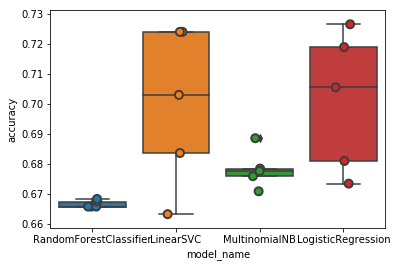

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [0]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.699622
LogisticRegression        0.701127
MultinomialNB             0.678324
RandomForestClassifier    0.666670
Name: accuracy, dtype: float64

The best model seems to be LogisticRegression

### Best Model Evaluation
Evaluation using confusion matrix / heat map between predicted and actual labels

In [0]:
X_train = df['object_labels']
X_test = df_test['object_labels']
y_train = df['tags_string']
y_test = df_test['tags_string']

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
lr = LogisticRegression().fit(X_train_tfidf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


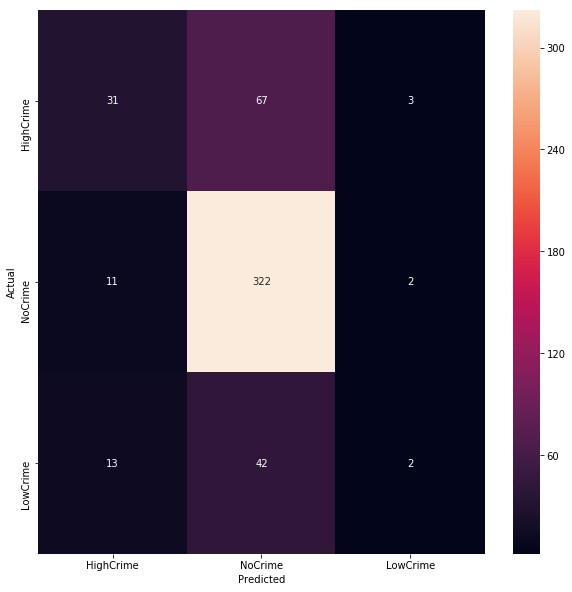

In [0]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.25, random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.tags_string.values, yticklabels=category_id_df.tags_string.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Model is the best at detecting no crime and better at detecting High crime over low crime, but still misclassfies some of them as no crime

### Some misclassifications

In [0]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['tags_string', 'object_labels']])
      print('')

'NoCrime' predicted as 'HighCrime' : 11 examples.


,tags_string,object_labels
85,NoCrime,"Human,Person,Apparel,Clothing,Path,Performer,C..."
230,NoCrime,"Human,Person,Transportation,Car,Automobile,Veh..."
1893,NoCrime,"Person,Human,Shop,Grocery Store,Supermarket,Ma..."
1148,NoCrime,"Person,Human,Advertisement,Poster,Text,Paper,F..."
260,NoCrime,"Human,Person,Military,Military Uniform,Armored..."
14,NoCrime,"Clothing,Apparel,Shoe,Footwear,Human,Person,We..."
444,NoCrime,"Human,Person,Restaurant,Chair,Furniture,Cafe,D..."
1782,NoCrime,"Person,Human,Weaponry,Weapon,Gun,Apparel,Cloth..."
724,NoCrime,"Human,Person,Workshop,Clothing,Apparel,Chair,F..."
1053,NoCrime,"Weaponry,Weapon,Gun,Armory,Human,Person,Handgu..."



'LowCrime' predicted as 'HighCrime' : 13 examples.


,tags_string,object_labels
1587,LowCrime,"Person,Human,Apparel,Clothing,People,Face,Vide..."
1832,LowCrime,"Furniture,Chair,Person,Human,Apparel,Clothing,..."
558,LowCrime,"Person,Human,Shop,Bazaar,Market,Shopping,Peopl..."
406,LowCrime,"Person,Human,Brick,Ninja,People,Clothing,Apparel"
1746,LowCrime,"Human,Person,Building,People,Machine"
1929,LowCrime,"Person,Human,Apparel,Clothing,People,Face,Elec..."
667,LowCrime,"Car,Transportation,Vehicle,Automobile,Human,Pe..."
559,LowCrime,"Human,Person,Shop,Market,Supermarket,Grocery S..."
5,LowCrime,"Person,Human,Police,Transportation,Vehicle,Aut..."
1074,LowCrime,"Clothing,Apparel,Helmet,Crash Helmet,Person,Hu..."



'HighCrime' predicted as 'NoCrime' : 67 examples.


,tags_string,object_labels
712,HighCrime,"Glove,Clothing,Apparel,Human,Person,Sports,Spo..."
1555,HighCrime,"Accessories,Goggles,Accessory"
1392,HighCrime,"Person,Human,Axe,Tool,Barefoot,Mud,Tribe"
1546,HighCrime,"Human,Person,Transportation,Car,Vehicle,Automo..."
1223,HighCrime,"Human,Person,Shoe,Footwear,Apparel,Clothing,Tr..."
1491,HighCrime,"Finger,Person,Human,Hand"
1784,HighCrime,"Human,Person,Face,Accessories,Accessory,Sungla..."
533,HighCrime,"Person,Face,Human,Dating,Crowd,People,Audience..."
1303,HighCrime,"Face,Person,Human,Female,Crowd,Woman,Text,Girl..."
53,HighCrime,"Person,Human,Indoors,Shop,Room,Bookstore,Book,..."



'LowCrime' predicted as 'NoCrime' : 42 examples.


,tags_string,object_labels
295,LowCrime,"Pants,Clothing,Apparel,Human,Person,Denim,Jean..."
530,LowCrime,"Balloon,Ball"
598,LowCrime,"Vehicle,Transportation,Automobile,Car,Nature,M..."
80,LowCrime,"Human,Person,Luggage,Suitcase,Indoors,Room,Court"
1171,LowCrime,"Road,Lighting,Town,Building,City,Street,Urban,..."
391,LowCrime,"Human,Person,Gas Pump,Machine,Pump,Costume,Clo..."
1739,LowCrime,"Person,Human,Pedestrian,Architecture,Clock Tow..."
1432,LowCrime,"Urban,Town,City,Building,High Rise,Flag,Symbol..."
1357,LowCrime,"Person,Human,Crowd,Press Conference,People"
1516,LowCrime,"Person,Human,Fire,Nature,Flame,Bonfire,People,..."


### Classification report

In [0]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['tags_string'].unique()))

              precision    recall  f1-score   support

   HighCrime       0.56      0.31      0.40       101
     NoCrime       0.75      0.96      0.84       335
    LowCrime       0.29      0.04      0.06        57

    accuracy                           0.72       493
   macro avg       0.53      0.43      0.43       493
weighted avg       0.66      0.72      0.66       493



## Prediction

In [0]:
print(lr.predict(count_vect.transform(["Person,Weapon,Gun,Advertisement,Poster,Brochure,Flyer,Paper,Clothing,Apparel,Text,Computer,Electronics,Hardware,Mouse,Outdoors"])))

['HighCrime']


To get probability in the order ```{'HighCrime, 'LowCrime', 'NoCrime': 2}```

In [0]:
print(clf.predict_proba(count_vect.transform(["Person,Weapon,Gun,Advertisement,Poster,Brochure,Flyer,Paper,Clothing,Apparel,Text,Computer,Electronics,Hardware,Mouse,Outdoors"])))

[[9.18329817e-01 5.97963344e-05 8.16103869e-02]]


## Save model

In [0]:
import pickle 
# Save the trained model as a pickle string. 
with open('model.pickle', 'wb') as handle:
    pickle.dump(clf, handle)

# Load the pickled model 
with open('model.pickle', 'rb') as saved_model:
    clf_from_pickle = pickle.load(saved_model)
  
# Use the loaded pickled model to make predictions 
clf_from_pickle.predict(count_vect.transform(["Person,Weapon,Gun,Advertisement,Poster,Brochure,Flyer,Paper,Clothing,Apparel,Text,Computer,Electronics,Hardware,Mouse,Outdoors"])) 



array(['HighCrime'], dtype='<U9')